In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from pyproj import Transformer, CRS

In [2]:
import xarray as xr

path = "/home/otto/s1_zarr/s5p/data/S5P_OFFL_L2__CO_____20240709T101748_20240709T115918_34916_03_020600_20240711T024017.nc.zip"
ds = xr.open_dataset(path, engine="netcdf4", group = "PRODUCT")

In [4]:
ds.load()

<xarray.Dataset> Size: 22MB
Dimensions:                                (scanline: 4172, ground_pixel: 215,
                                            time: 1, corner: 4, layer: 50)
Coordinates:
  * scanline                               (scanline) float64 33kB 0.0 ... 4....
  * ground_pixel                           (ground_pixel) float64 2kB 0.0 ......
  * time                                   (time) datetime64[ns] 8B 2024-07-09
  * corner                                 (corner) float64 32B 0.0 1.0 2.0 3.0
  * layer                                  (layer) float32 200B 4.95e+04 ... ...
    latitude                               (time, scanline, ground_pixel) float32 4MB ...
    longitude                              (time, scanline, ground_pixel) float32 4MB ...
Data variables:
    delta_time                             (time, scanline) datetime64[ns] 33kB ...
    time_utc                               (time, scanline) object 33kB '2024...
    qa_value                               (time, scanline, ground_pixel) float32 4MB ...
    carbonmonoxide_total_column            (time, scanline, ground_pixel) float32 4MB ...
    carbonmonoxide_total_column_precision  (time, scanline, ground_pixel) float32 4MB ...
    carbonmonoxide_total_column_corrected  (time, scanline, ground_pixel) float32 4MB ...

In [199]:
from pyproj import Transformer, CRS
from shapely import box
"""transformer = Transformer.from_crs("EPSG:27704", "EPSG:4326", always_xy=True)
x,y = 5400000, 1800000
lon_max, lat_max = transformer.transform(x, y)
x,y = 4500000, 1200000
lon_min, lat_min = transformer.transform(x,y)
"""
lon_min, lat_min, lon_max, lat_max=7.446984362945015, 43.37534399491647, 17.90341725721117, 49.94613742754262

austria_bbox = box(lon_min, lat_min, lon_max, lat_max)

In [200]:
ds = ds[["longitude", "latitude", "carbonmonoxide_total_column_corrected"]].load()
ds = ds.set_coords(["longitude", "latitude"])
mask = (
    (ds["latitude"] >= lat_min) & (ds["latitude"] <= lat_max) &
    (ds["longitude"] >= lon_min) & (ds["longitude"] <= lon_max)
)

ds_subset = ds.where(mask, drop=True)

In [165]:
ds_subset = ds_subset.rio.write_crs("EPSG:4326", inplace=False)

In [166]:
import numpy as np
ds_band = ds_subset.squeeze()#.isel(wavelength=1)
#ds_band["aerosol_optical_thickness"].values = np.random.randint(0,100, size=(179,184))

In [168]:
# Extract variables
lst_original = ds_band["carbonmonoxide_total_column_corrected"] 
lat_original = ds_band["latitude"]
lon_original = ds_band["longitude"]

In [169]:
lat_min, lat_max = lat_original.min().item(), lat_original.max().item()
lon_min, lon_max = lon_original.min().item(), lon_original.max().item()
lat_min, lat_max, lon_min, lon_max

(40.378318786621094, 53.300498962402344, 5.187127590179443, 20.710086822509766)

In [170]:
target_resolution = 0.1

# Compute number of points based on extent and resolution for full extent
n_points_lat_full = int(np.ceil((lat_max - lat_min) / target_resolution)) + 1
n_points_lon_full = int(np.ceil((lon_max - lon_min) / target_resolution)) + 1
target_lat_full = np.linspace(lat_min, lat_max, n_points_lat_full)
target_lon_full = np.linspace(lon_min, lon_max, n_points_lon_full)
lon_grid_full, lat_grid_full = np.meshgrid(target_lon_full, target_lat_full)

In [171]:
aot_regridded_full = griddata(
    (lon_original.values.flatten(), lat_original.values.flatten()),
    lst_original.values.flatten(),
    (lon_grid_full, lat_grid_full),
    method="linear",
)
print("Regridding completed.")
print(
    f"Regridded AOT (Full Extent) shape: {aot_regridded_full.shape} (lat points: {n_points_lat_full}, lon points: {n_points_lon_full})"
)

Regridding completed.
Regridded AOT (Full Extent) shape: (131, 157) (lat points: 131, lon points: 157)


In [173]:
import numpy as np
import rasterio
from rasterio.transform import from_origin
from rasterio.warp import calculate_default_transform, reproject, Resampling

def reproject_numpy_to_equi7_eu_1km(
    data, lons, lats, nodata=np.nan, resampling="bilinear"
):

    assert data.ndim == 2 and data.shape == (len(lats), len(lons))

    if lats[0] < lats[-1]:
        data = data[::-1, :]
        lats = lats[::-1]

    xres = float(abs(lons[1] - lons[0]))
    yres = float(abs(lats[1] - lats[0]))
    west = float(lons.min())
    north = float(lats.max())
    src_transform = from_origin(west - xres/2, north + yres/2, xres, yres)
    src_crs = "EPSG:4326"

    dst_crs = "EPSG:27704"
    out_res = 10000.0

    left, bottom, right, top = rasterio.transform.array_bounds(
        data.shape[0], data.shape[1], src_transform
    )
    dst_transform, dst_w, dst_h = calculate_default_transform(
        src_crs, dst_crs, data.shape[1], data.shape[0],
        left, bottom, right, top, resolution=out_res
    )

    from math import floor
    x0 = floor(dst_transform.c / out_res) * out_res
    y0 = floor(dst_transform.f / out_res) * out_res
    dst_transform = rasterio.Affine(out_res, 0, x0, 0, -out_res, y0)

    dst = np.full((dst_h, dst_w), nodata, dtype=data.dtype)
    reproject(
        source=data,
        destination=dst,
        src_transform=src_transform,
        src_crs=src_crs,
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        resampling=getattr(Resampling, resampling),
        src_nodata=nodata,
        dst_nodata=nodata,
    )
    return dst, dst_transform, dst_crs

In [174]:
arr_1km, tr_1km, crs_1km = reproject_numpy_to_equi7_eu_1km(
    aot_regridded_full, target_lon_full, target_lat_full,
    nodata=np.nan,                 # or np.nan for floats
    resampling="bilinear"          # use "nearest" for labels; "bilinear"/"cubic" for continuous
)

In [ ]:
def pixel_center_coords(transform, width, height):
    """
    Returns 2D arrays X, Y with the projected coordinates
    of each pixel center given an affine transform.
    """
    # Column indices (0..width-1)
    cols = np.arange(width)
    # Row indices (0..height-1)
    rows = np.arange(height)

    # Convert pixel indices to map coords (center positions)
    xs = transform.c + cols * transform.a + transform.b * 0
    ys = transform.f + rows * transform.e + transform.d * 0

    # Meshgrid to 2D arrays
    X, Y = np.meshgrid(xs, ys)
    return X, Y

# Example usage after reprojection:
# arr_1km, tr_1km, crs_1km = reproject_numpy_to_equi7_eu_1km(...)
X, Y = pixel_center_coords(tr_1km, arr_1km.shape[1], arr_1km.shape[0])

print(X.shape, Y.shape)   # both (rows, cols)
print(X.min(), X.max())   # extent in x
print(Y.min(), Y.max())   # extent in y


(161, 139) (161, 139)
4230000.0 5610000.0
720000.0 2320000.0


In [ ]:
transformer = Transformer.from_crs("EPSG:27704", "EPSG:4326", always_xy=True)
x,y = 5400000, 1800000
lon_max, lat_max = transformer.transform(x, y)
x,y = 4500000, 1200000
lon_min, lat_min = transformer.transform(x,y)

In [179]:
lons_new, lats_new = transformer.transform(X,Y)

In [187]:
np.nanmin(arr_1km)

np.float64(0.021852464418743243)

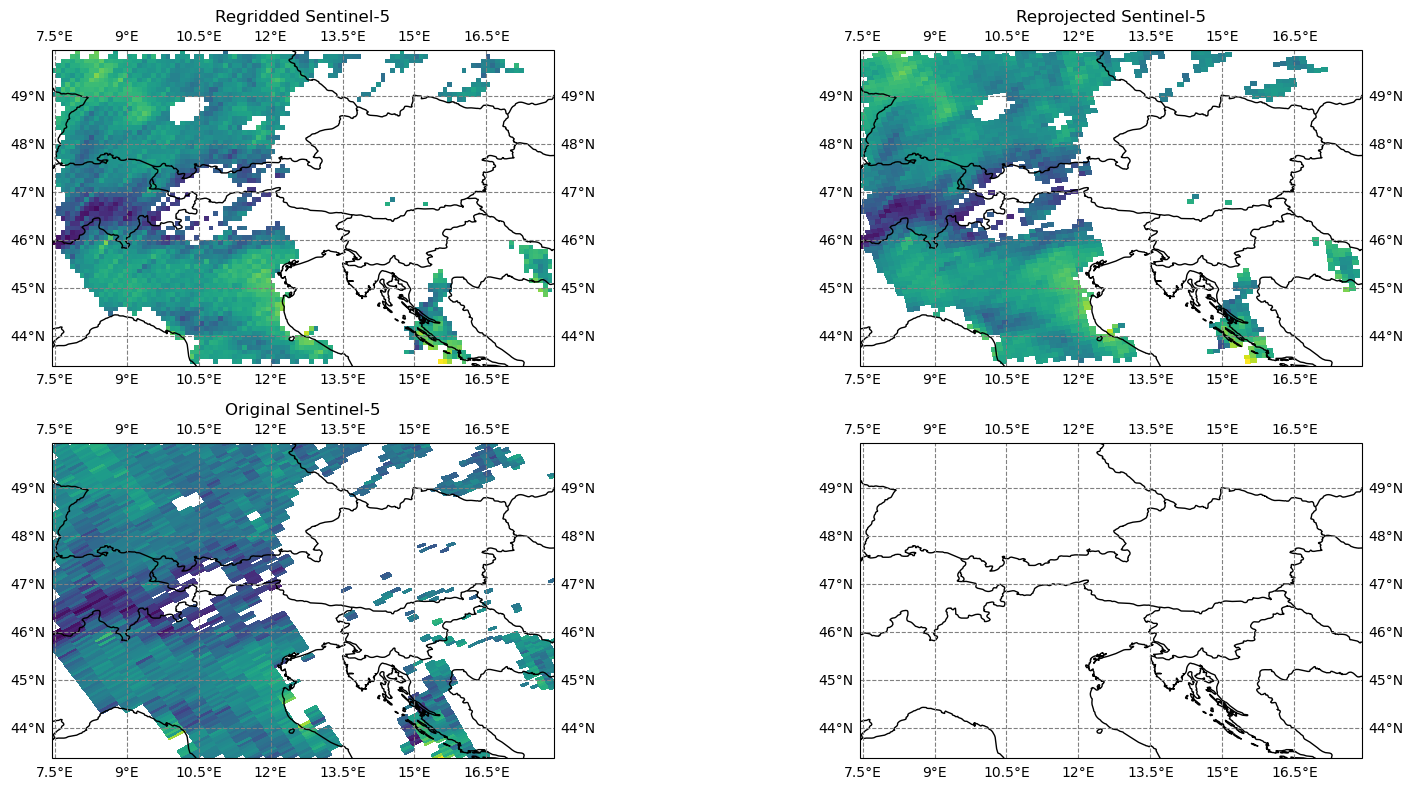

In [181]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(17, 8), subplot_kw={"projection": ccrs.PlateCarree()})
axs=axs.flatten()
axs[0].pcolormesh(lon_grid_full, lat_grid_full, aot_regridded_full, cmap="viridis")#, vmin=-2, vmax=1)
axs[1].pcolormesh(lons_new, lats_new, arr_1km, transform=ccrs.PlateCarree(), cmap="viridis")#, vmin=-2, vmax=1)
axs[2].pcolormesh(lon_original, lat_original, lst_original, cmap="viridis")#, vmin=-2, vmax=1)

for ax in axs:
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    
    #ax.set_xlabel("Longitude (°E)")
    #ax.set_ylabel("Latitude (°N)")
    ax.gridlines(draw_labels=True, color="gray", linestyle="--")
    ax.set_xlim(lon_min, lon_max)
    ax.set_ylim(lat_min, lat_max)

axs[0].set_title("Regridded Sentinel-5")
axs[1].set_title("Reprojected Sentinel-5")
axs[2].set_title("Original Sentinel-5")

#plt.colorbar(mappable, ax=ax, label="AOT")
plt.tight_layout()
plt.show()